# 加3層cnn 

In [1]:
project_PATH = '/home/sail/sound_project/sound_ai_v3'
# step_now = 'STEP/step_1'
step_now = 'sys/step_1_base_model'

save_model_name = '6C_model_v3'

save_name = 'model_6C_v3_1028_pr09_byChristine.cc'

Data_npz_path = f'/home/sail/sound_project/DATA/using_data_v3/data_v3.npz'

In [2]:
import os
print(os.getcwd())
import sys
sys.path.append(os.path.abspath(f'{project_PATH}/common'))

import utils as U
import opts as opts;
import calculator as calc;
import tlopts as tlopts
import agent_attention_pytorch as att

from config_utility import *

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from datetime import datetime

/home/sail/sound_project/sound_ai_v3/sys


In [3]:
import sys;
import os;
import glob;
import math;
import numpy as np;
import glob;
import random;
from collections import Counter 
import time;

import torch;
from torch.utils.data import  DataLoader
import torch.optim as optim;
import torch.nn as nn;
import torch.nn.functional as F
import json

import argparse
from itertools import repeat
import pathlib

from datetime import datetime;

In [4]:
sys.path.append(os.path.abspath(f'{project_PATH}/STEP/sys'))

from model import att_Model
from trainer import TLTrainer

In [5]:

data = np.load(Data_npz_path, allow_pickle=True) 
# audio_max_value =  float((data['sounds_train']).max()) # *2 # the max value of the sound samples
# audio_min_value =  float((data['sounds_train']).min()) # *2 # the max value of the sound samples
print("train",Counter(data['labels_train'].tolist()), "\n val",Counter(data['labels_val'].tolist()))
# audio_max_value, audio_min_value

train Counter({0: 4142, 2: 1520, 4: 828, 7: 804, 1: 512, 5: 214, 3: 203, 6: 84}) 
 val Counter({4: 40, 5: 31, 2: 30, 3: 30, 1: 30, 7: 24, 0: 20, 6: 6})


In [6]:
def genDataTimeStr():
    return datetime.today().strftime('%Y-%m-%d %H:%M:%S').replace('-',"").replace(' ',"").replace(':',"");

def getDateStr():
    return datetime.today().strftime('%Y-%m-%d %H').replace('-',"").replace(' ',"")

In [7]:
threshold = 0.5

map_dict_train = {0:1, 1:2, 2:3, 3:4, 4:5, 5:6, 6:7,};

# map_dict_train = {0:1, 1:2, 2:3, 3:4, 4:5, 5:6};

choose_class = [0,1,2,3,4,5,6,7]

pr_rate = 0.8

In [8]:
def getOpts():
    parser = argparse.ArgumentParser(description='!NO! Transfer Learning and add attention');
    parser.add_argument('--netType', default='add_attention',  required=False);
    parser.add_argument('--BC', default=True, action='store_true', help='BC learning');
    # parser.add_argument('--data', default='../datasets/processed/',  required=False);
    parser.add_argument('--dataset', required=False, default='v3', choices=['10']);
    
    opt, _ = parser.parse_known_args(); #在ipynb中，不能使用parser.parse，要改用parser.parse_known_args()

    opt.project_PATH = project_PATH
    #Basic Net Settings
    opt.nClasses = len(choose_class) #
    opt.threshold = threshold
    opt.nFolds = 1; #
    opt.splits = [i for i in range(1, opt.nFolds + 1)];
    opt.sr = 16000;
    opt.inputLength = 16000;

    opt.Data_npz_path = Data_npz_path
    opt.classes_dict = {0:1, 1:2, 2:3, 3:4, 4:5, 5:6, 6:7,};
    # opt.audio_max_value = audio_max_value
    opt.other_class = 0
    opt.choose_or_not = True 
    opt.choose_class = choose_class
    
    #Leqarning settings
    opt.ch_confing_10 = 32
    opt.fcn_no_of_inputs = opt.nClasses
    opt.ch_n_class = opt.nClasses

    opt.batch_size =  64;
    opt.batchSize = opt.batch_size 
    opt.lr = 0.1; # 0.1
    opt.weightDecay = 5e-4 #9e-3;#5e-3;#5e-2;#1e-2;#5e-4;
    opt.momentum = 0.9 # 0.9;
    # opt.nEpochs = 300; # 1600
    opt.nEpochs = 300; # 1600
    opt.schedule = [0.3, 0.5, 0.9];
    opt.warmup = 10;
    
    opt.least_save_epoch = 5;
    opt.first_save_acc = 75.0;
    opt.save_val_acc = 99.0;
    opt.save_train_acc = 90.0;


    if torch.backends.mps.is_available():
        opt.device="mps"; #for apple m2 gpu
    elif torch.cuda.is_available():
        opt.device="cuda:0"; #for nVidia gpu
    else:
        opt.device="cpu"

    print(f"***Use device:{opt.device}");

    #Test data
    opt.nCrops = 1;
    opt.TLAcdnetConfig = []

    return opt
    # opt = parser.parse_args();

In [9]:
def ChkAndCreateSingleDir(dir_path):
    if not pathlib.Path(dir_path).is_dir():
        os.mkdir(dir_path);
        print(f"'{dir_path}' folder is created.");

## step1

In [10]:
date_time = datetime.now().strftime("%Y%m%d_%H")  # %M
try:
    os.mkdir(f'{project_PATH}/{step_now}/save_pt_model_s1')
except FileExistsError:
    pass
save_pt_model_path = f'{project_PATH}/{step_now}/save_pt_model_s1/{date_time}'
try:
    os.mkdir(save_pt_model_path)
    print(f"Folder '{save_pt_model_path}' created successfully.")
except FileExistsError:
    print(f"Folder '{save_pt_model_path}' already exists.")

Folder '/home/sail/sound_project/sound_ai_v3/sys/step_1_base_model/save_pt_model_s1/20241030_14' created successfully.


In [11]:
logObj = None;
def main():
    global logObj;
    opt = getOpts()
    opt.best_save_name = None
    opt.trainStartTime = genDataTimeStr();
    opt.modelSaveDir = f'{save_pt_model_path}/base4C_train_lr{opt.lr}_bs{opt.batch_size}_wd{opt.weightDecay}_{opt.trainStartTime}/'

    if not pathlib.Path(opt.modelSaveDir).is_dir():
        os.makedirs(opt.modelSaveDir,exist_ok=True);
        print(f"'{opt.modelSaveDir}' is created.");
    tlopts.display_info(opt)
    opt.model_name = save_model_name+"hacc{:.4f}_valacc{:.4f}_hacctr{:.4f}_tracc{:.4f}_{}th_sum_{:.4f}.pt"
    ###
    logSaveDir = opt.modelSaveDir + "/base_training_logs/"
    opt.logSaveDir = logSaveDir
    ChkAndCreateSingleDir(logSaveDir);
    opt.logName = "BaseTrainLog_{}.log".format(opt.trainStartTime);
    opt.logObj = open(os.path.join(logSaveDir,opt.logName),'w');

    print("Initializing TLTrainer Object.....")
    trainer = TLTrainer(opt)
    print("Start to training.....")
    model = trainer.Train();

    return opt.best_save_name

***Use device:cpu
'/home/sail/sound_project/sound_ai_v3/sys/step_1_base_model/save_pt_model_s1/20241030_14/base4C_train_lr0.1_bs64_wd0.0005_20241030144100/' is created.
+------------------------------+
| add_attention Sound classification
+------------------------------+
| dataset  : v3
| nEpochs  : 300
| LRInit   : 0.1
| batchSize: 64
| Momentum   : 0.9
| weightDecay: 0.0005
| schedule : [0.3, 0.5, 0.9]
| warmup   : 10
| nFolds: 1
| Splits: [1]
+------------------------------+
'/home/sail/sound_project/sound_ai_v3/sys/step_1_base_model/save_pt_model_s1/20241030_14/base4C_train_lr0.1_bs64_wd0.0005_20241030144100//base_training_logs/' folder is created.
Initializing TLTrainer Object.....


/home/uecai/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:128: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


random other
Start to training.....
self.opt.ch_confing_10 32
self.ch_config [1, 16, 32, 1, 64, 32, 64, 32, 16, 16, 6]
sfeb.0.weight:True
sfeb.1.weight:True
sfeb.1.bias:True
sfeb.3.weight:True
sfeb.4.weight:True
sfeb.4.bias:True
tfeb.0.weight:True
tfeb.1.weight:True
tfeb.1.bias:True
tfeb.4.weight:True
tfeb.5.weight:True
tfeb.5.bias:True
tfeb.7.weight:True
tfeb.8.weight:True
tfeb.8.bias:True
tfeb.11.weight:True
tfeb.12.weight:True
tfeb.12.bias:True
tfeb.14.weight:True
tfeb.15.weight:True
tfeb.15.bias:True
tfeb.19.weight:True
tfeb.19.bias:True
ACDNet model has been prepared for training
+----------------------------------------------------------------------------+
+                           Pytorch Model Summary                            +
------------------------------------------------------------------------------
   Layer (type)       Input Shape      Output Shape    Param #      FLOPS #
       Conv2d-1     (1, 1, 16000)     (16, 1, 7996)        144    1,151,424
  BatchNorm2d-2    

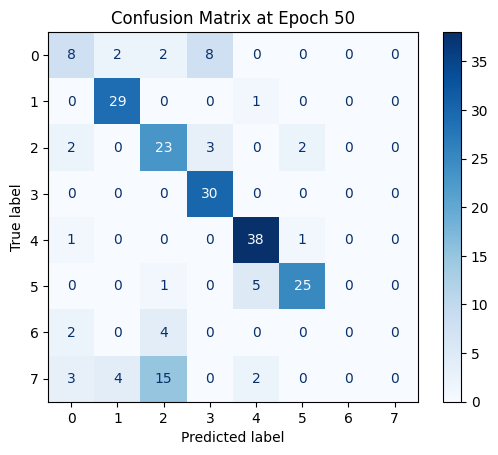

/home/uecai/.local/lib/python3.10/site-packages/matplotlib/axes/_base.py:2985: RuntimeWarning: overflow encountered in scalar add
  x0, x1 = inverse_trans.transform([x0t - delta, x1t + delta])


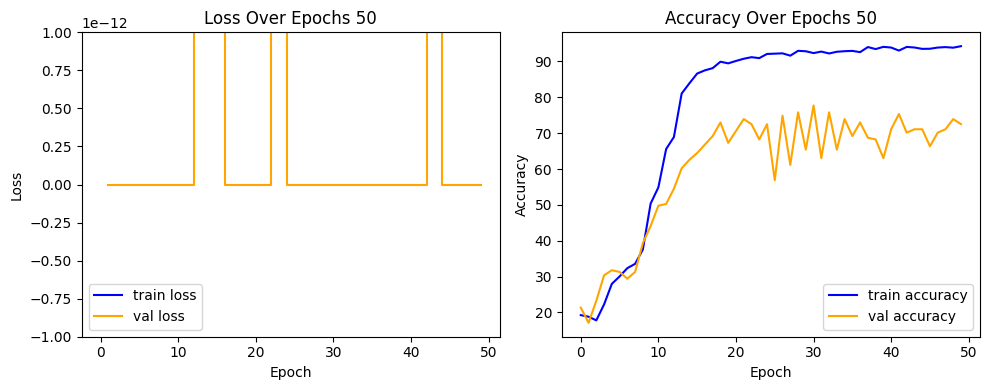

save model to /home/sail/sound_project/sound_ai_v3/sys/step_1_base_model/save_pt_model_s1/20241030_14/base4C_train_lr0.1_bs64_wd0.0005_20241030144100/6C_model_v3hacc77.7251_valacc68.7204_hacctr94.2767_tracc94.2767_51th_sum_334.9989.pt
SP-[1] Epoch: 51/300 | Time: 0m54s (Train 0m54s  Val 0m00s) | Train: lr 0.1  Loss 1.0459  Acc 94.28% | HA 94.28@51 | Val: Loss 1.4004  Acc 68.72% | HA 77.73@31 | Sum 163.00 HA 172.00
save model to /home/sail/sound_project/sound_ai_v3/sys/step_1_base_model/save_pt_model_s1/20241030_14/base4C_train_lr0.1_bs64_wd0.0005_20241030144100/6C_model_v3hacc77.7251_valacc65.4028_hacctr94.2767_tracc94.2591_51th_sum_331.6638.pt
SP-[1] Epoch: 52/300 | Time: 0m59s (Train 0m59s  Val 0m00s) | Train: lr 0.1  Loss 1.0489  Acc 94.26% | HA 94.28@51 | Val: Loss 1.4995  Acc 65.40% | HA 77.73@31 | Sum 159.66 HA 172.00
save model to /home/sail/sound_project/sound_ai_v3/sys/step_1_base_model/save_pt_model_s1/20241030_14/base4C_train_lr0.1_bs64_wd0.0005_20241030144100/6C_model_v3hac

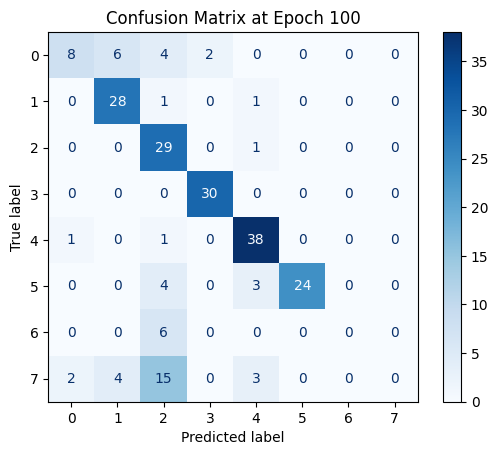

/home/uecai/.local/lib/python3.10/site-packages/matplotlib/axes/_base.py:2985: RuntimeWarning: overflow encountered in scalar add
  x0, x1 = inverse_trans.transform([x0t - delta, x1t + delta])


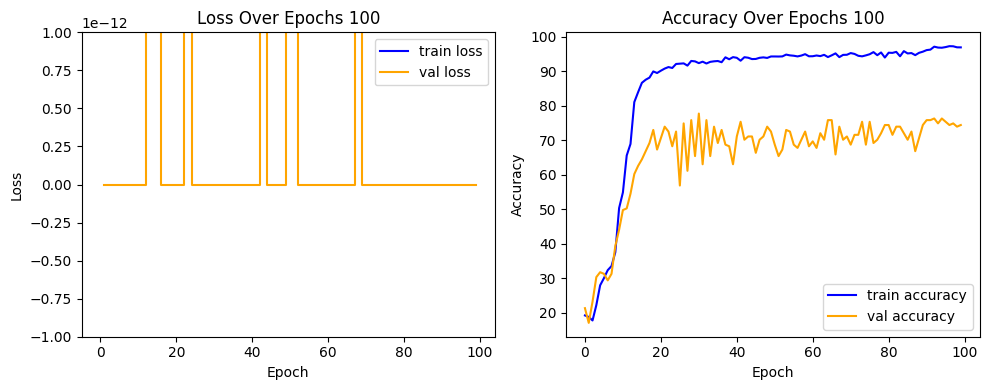

save model to /home/sail/sound_project/sound_ai_v3/sys/step_1_base_model/save_pt_model_s1/20241030_14/base4C_train_lr0.1_bs64_wd0.0005_20241030144100/6C_model_v3hacc77.7251_valacc76.3033_hacctr97.2612_tracc97.1208_100th_sum_348.4105.pt
SP-[1] Epoch: 101/300 | Time: 1m05s (Train 1m04s  Val 0m00s) | Train: lr 0.010000000000000002  Loss 1.0318  Acc 97.12% | HA 97.26@97 | Val: Loss nan  Acc 76.30% | HA 77.73@31 | Sum 173.42 HA 174.99
save model to /home/sail/sound_project/sound_ai_v3/sys/step_1_base_model/save_pt_model_s1/20241030_14/base4C_train_lr0.1_bs64_wd0.0005_20241030144100/6C_model_v3hacc77.7251_valacc76.3033_hacctr97.2612_tracc97.1383_101th_sum_348.4280.pt
SP-[1] Epoch: 102/300 | Time: 0m56s (Train 0m56s  Val 0m00s) | Train: lr 0.010000000000000002  Loss 1.0349  Acc 97.14% | HA 97.26@97 | Val: Loss nan  Acc 76.30% | HA 77.73@31 | Sum 173.44 HA 174.99
save model to /home/sail/sound_project/sound_ai_v3/sys/step_1_base_model/save_pt_model_s1/20241030_14/base4C_train_lr0.1_bs64_wd0.00

In [12]:
step_1_model_path = main()
# main()


In [ ]:
step_1_model_path

'/home/sail/sound_project/sound_ai_v3/sys/step_1_base_model/save_pt_model_s1/20241030_11/base4C_train_lr0.1_bs64_wd0.0005_20241030113657/6C_model_v3hacc95.4023_valacc94.8276_hacctr98.1618_tracc97.8125_149th_sum_386.2041.pt'

## step 2

In [ ]:
step_now = 'sys/step_2_pruning'

In [ ]:
# step_1_model_path = '/home/sail/sound_project/sound_ai_v2.2.2/sys/step1_base_model/save_pt_model_s1/20241007_17/base4C_train_lr0.1_bs64_wd0.0005_20241007173709/6C_att_model_hacc100.0000_valacc99.1071_hacctr90.5093_tracc90.5093_298th_sum_380.1257.pt'

In [ ]:
date_time = datetime.now().strftime("%Y%m%d_%H")  # %M
save_step_path = f'{project_PATH}/{step_now}'
save_pt_model_path = f'{save_step_path}/{date_time}'
try:
    os.mkdir(f'{project_PATH}/{step_now}')
    os.mkdir(save_step_path)
    print(f"Folder '{save_step_path}' created successfully.")
except FileExistsError:
    print(f"Folder '{save_step_path}' already exists.")
    
save_step_path = f'{project_PATH}/{step_now}/save_pt_model_s2'

try:
    os.mkdir(f'{project_PATH}/{step_now}')
    os.mkdir(save_step_path)
    print(f"Folder '{save_step_path}' created successfully.")
except FileExistsError:
    print(f"Folder '{save_step_path}' already exists.")
    
try:
    os.mkdir(save_pt_model_path)
    print(f"Folder '{save_pt_model_path}' created successfully.")
except FileExistsError:
    print(f"Folder '{save_pt_model_path}' already exists.")

Folder '/home/sail/sound_project/sound_ai_v3/sys/step_2_pruning' already exists.
Folder '/home/sail/sound_project/sound_ai_v3/sys/step_2_pruning/save_pt_model_s2' already exists.
Folder '/home/sail/sound_project/sound_ai_v3/sys/step_2_pruning/20241030_13' created successfully.


In [ ]:
from sparsify import PruningTrainer


In [ ]:
def main():
    global logObj;
    opt = getOpts()
    opt.trainer = None

    # opt.nEpochs = 300;
    # opt.least_save_epoch = 50;
    # opt.first_save_acc = 75.0;
    # opt.save_val_acc = 95.0;
    opt.save_train_acc = 90.0;

    opt.prune_ratio = pr_rate
    opt.base_model_path = step_1_model_path
    trainStartTime = getDateStr();
    save_dir = f"{save_pt_model_path}/pruning_4C_time_{trainStartTime}_prunratio{opt.prune_ratio*100}/"
    if not os.path.exists(save_dir):
        os.mkdir(save_dir)
    opt.save_dir = save_dir;
    opt.model_name = save_model_name+"_first_stage_prun_haacc_{:.4f}_valacc{:.4f}_tracc{:.4f}_epoch_{}.pt";
    print("Initializing PruneAndTrain Object.....")
    trainer = PruningTrainer(opt)#TLTrainer(opt)
    print("Start to pruning.....")
    logSaveDir = opt.save_dir+"/first_stage_pruning_logs/"
    opt.logSaveDir = logSaveDir
    ChkAndCreateSingleDir(logSaveDir);
    logName = "FirstPruningLog_{}.log".format(trainStartTime);
    opt.logObj = open(os.path.join(logSaveDir,logName),'w');
    trainer.PruneAndTrain();
    opt.logObj.flush();
    opt.logObj.close();
    return opt.best_save_name

***Use device:cpu
Initializing PruneAndTrain Object.....
random other
random other
!!! In PruningTrainer:: current used device:cpu
Start to pruning.....
'/home/sail/sound_project/sound_ai_v3/sys/step_2_pruning/20241030_13/pruning_4C_time_2024103013_prunratio80.0//first_stage_pruning_logs/' folder is created.
cpu
self.opt.ch_confing_10 32
self.ch_config [1, 16, 32, 1, 64, 32, 64, 32, 16, 16, 6]
+----------------------------------------------------------------------------+
+                           Pytorch Model Summary                            +
------------------------------------------------------------------------------
   Layer (type)       Input Shape      Output Shape    Param #      FLOPS #
       Conv2d-1     (1, 1, 16000)     (16, 1, 7996)        144    1,151,424
  BatchNorm2d-2     (16, 1, 7996)     (16, 1, 7996)         32            0
         ReLu-3     (16, 1, 7996)     (16, 1, 7996)          0      127,936
       Conv2d-4     (16, 1, 7996)     (32, 1, 3996)      2,560

/home/sail/sound_project/sound_ai_v3/sys/sparsify.py:65: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load(self.opt.base_model_path, map_location=

save model to /home/sail/sound_project/sound_ai_v3/sys/step_2_pruning/20241030_13/pruning_4C_time_2024103013_prunratio80.0/6C_model_v3_first_stage_prun_haacc_89.6552_valacc89.6552_tracc96.6176_epoch_1.pt
SP-[1] Epoch: 1/300 | Time: 0m22s (Train 0m22s  Val 0m00s) | Train: lr 0.010000000000000002  Loss 0.8161  Acc 96.62% | HA 0.00@0 | Val: Loss nan  Acc 89.66% | HA 0.00@0 | Sum 186.27 HA 0.00
SP-[1] Epoch: 2/300 | Time: 0m22s (Train 0m22s  Val 0m00s) | Train: lr 0.010000000000000002  Loss 0.8057  Acc 97.70% | HA 0.00@0 | Val: Loss nan  Acc 86.21% | HA 0.00@0 | Sum 183.91 HA 0.00
SP-[1] Epoch: 3/300 | Time: 0m22s (Train 0m22s  Val 0m00s) | Train: lr 0.010000000000000002  Loss 0.8067  Acc 97.15% | HA 0.00@0 | Val: Loss 0.0813  Acc 85.06% | HA 0.00@0 | Sum 182.21 HA 0.00
SP-[1] Epoch: 4/300 | Time: 0m22s (Train 0m22s  Val 0m00s) | Train: lr 0.010000000000000002  Loss 0.8040  Acc 97.63% | HA 0.00@0 | Val: Loss nan  Acc 86.21% | HA 0.00@0 | Sum 183.84 HA 0.00
SP-[1] Epoch: 5/300 | Time: 0m22s

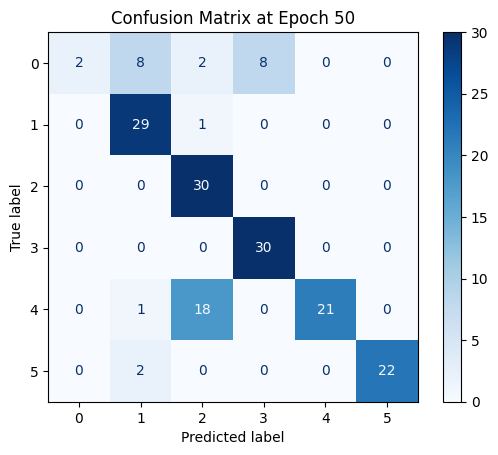

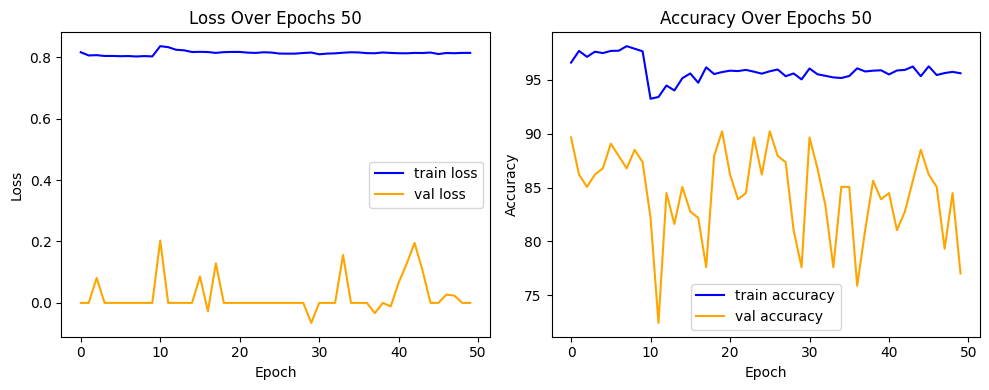

save model to /home/sail/sound_project/sound_ai_v3/sys/step_2_pruning/20241030_13/pruning_4C_time_2024103013_prunratio80.0/6C_model_v3_first_stage_prun_haacc_90.2299_valacc82.7586_tracc95.4044_epoch_51.pt
SP-[1] Epoch: 51/300 | Time: 0m22s (Train 0m22s  Val 0m00s) | Train: lr 0.1  Loss 0.8150  Acc 95.40% | HA 0.00@0 | Val: Loss 0.0302  Acc 82.76% | HA 0.00@0 | Sum 178.16 HA 0.00
save model to /home/sail/sound_project/sound_ai_v3/sys/step_2_pruning/20241030_13/pruning_4C_time_2024103013_prunratio80.0/6C_model_v3_first_stage_prun_haacc_90.2299_valacc89.6552_tracc95.5331_epoch_52.pt
SP-[1] Epoch: 52/300 | Time: 0m22s (Train 0m21s  Val 0m00s) | Train: lr 0.1  Loss 0.8137  Acc 95.53% | HA 0.00@0 | Val: Loss nan  Acc 89.66% | HA 0.00@0 | Sum 185.19 HA 0.00
save model to /home/sail/sound_project/sound_ai_v3/sys/step_2_pruning/20241030_13/pruning_4C_time_2024103013_prunratio80.0/6C_model_v3_first_stage_prun_haacc_90.2299_valacc85.0575_tracc95.7353_epoch_53.pt
SP-[1] Epoch: 53/300 | Time: 0m22s

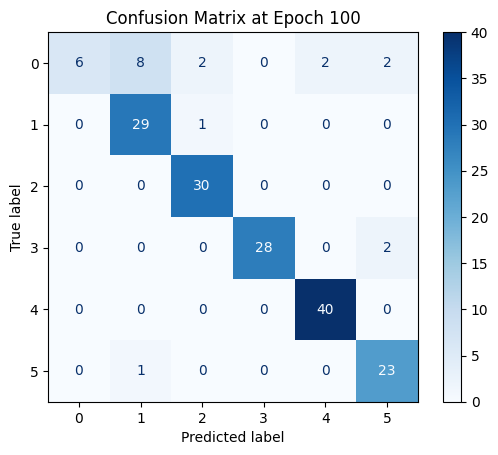

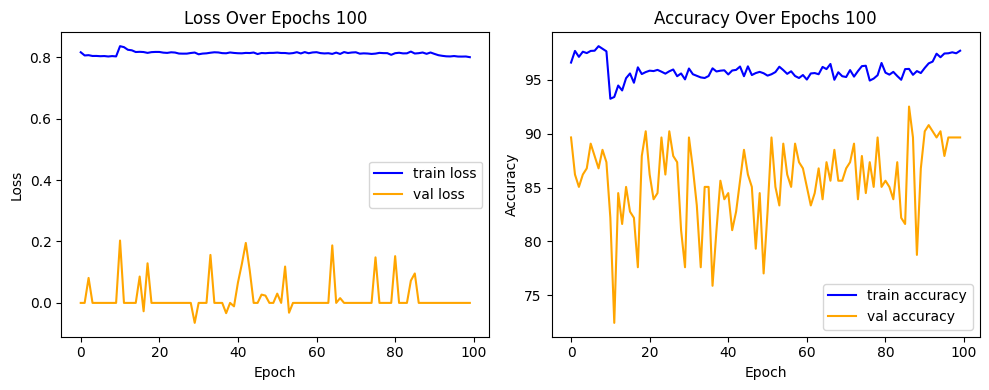

save model to /home/sail/sound_project/sound_ai_v3/sys/step_2_pruning/20241030_13/pruning_4C_time_2024103013_prunratio80.0/6C_model_v3_first_stage_prun_haacc_92.5287_valacc89.6552_tracc97.4265_epoch_101.pt
SP-[1] Epoch: 101/300 | Time: 0m22s (Train 0m22s  Val 0m00s) | Train: lr 0.010000000000000002  Loss 0.8012  Acc 97.43% | HA 0.00@0 | Val: Loss nan  Acc 89.66% | HA 0.00@0 | Sum 187.08 HA 0.00
save model to /home/sail/sound_project/sound_ai_v3/sys/step_2_pruning/20241030_13/pruning_4C_time_2024103013_prunratio80.0/6C_model_v3_first_stage_prun_haacc_92.5287_valacc89.0805_tracc97.7022_epoch_102.pt
SP-[1] Epoch: 102/300 | Time: 0m22s (Train 0m22s  Val 0m00s) | Train: lr 0.010000000000000002  Loss 0.8023  Acc 97.70% | HA 0.00@0 | Val: Loss nan  Acc 89.08% | HA 0.00@0 | Sum 186.78 HA 0.00
save model to /home/sail/sound_project/sound_ai_v3/sys/step_2_pruning/20241030_13/pruning_4C_time_2024103013_prunratio80.0/6C_model_v3_first_stage_prun_haacc_92.5287_valacc89.0805_tracc97.6287_epoch_103.p

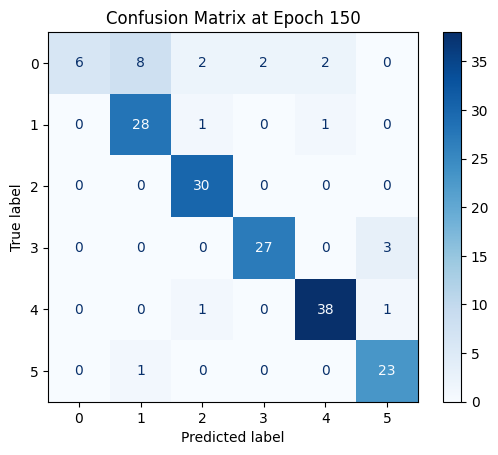

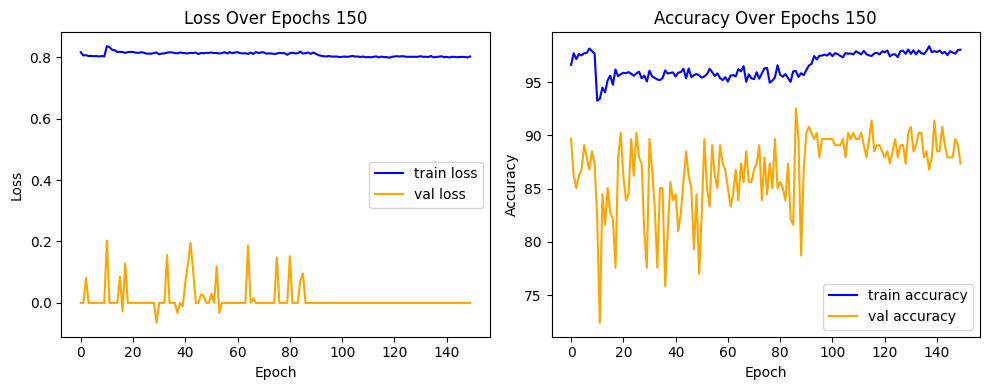

save model to /home/sail/sound_project/sound_ai_v3/sys/step_2_pruning/20241030_13/pruning_4C_time_2024103013_prunratio80.0/6C_model_v3_first_stage_prun_haacc_92.5287_valacc86.2069_tracc97.8860_epoch_151.pt
SP-[1] Epoch: 151/300 | Time: 0m22s (Train 0m21s  Val 0m00s) | Train: lr 0.0010000000000000002  Loss 0.8013  Acc 97.89% | HA 0.00@0 | Val: Loss nan  Acc 86.21% | HA 0.00@0 | Sum 184.09 HA 0.00
save model to /home/sail/sound_project/sound_ai_v3/sys/step_2_pruning/20241030_13/pruning_4C_time_2024103013_prunratio80.0/6C_model_v3_first_stage_prun_haacc_92.5287_valacc87.3563_tracc97.9963_epoch_152.pt
SP-[1] Epoch: 152/300 | Time: 0m21s (Train 0m21s  Val 0m00s) | Train: lr 0.0010000000000000002  Loss 0.8006  Acc 98.00% | HA 0.00@0 | Val: Loss nan  Acc 87.36% | HA 0.00@0 | Sum 185.35 HA 0.00
save model to /home/sail/sound_project/sound_ai_v3/sys/step_2_pruning/20241030_13/pruning_4C_time_2024103013_prunratio80.0/6C_model_v3_first_stage_prun_haacc_92.5287_valacc87.3563_tracc97.9779_epoch_153

In [ ]:
step_2_model_path = main()


In [ ]:
step_2_model_path

'/home/sail/sound_project/sound_ai_v3/sys/step_2_pruning/20241029_12/pruning_4C_time_2024102912_prunratio90.0/6C_model_v3_first_stage_prun_haacc_90.8046_valacc90.2299_tracc96.4338_epoch_100.pt'

## step3

In [ ]:
# step_2_model_path = '/home/sail/sound_project/sound_ai_v3/sys/step_2_pruning/20241029_12/pruning_4C_time_2024102912_prunratio90.0/6C_model_v3_first_stage_prun_haacc_90.8046_valacc90.2299_tracc96.4338_epoch_100.pt'

In [ ]:
step_now = 'sys/step_3_pruning'
date_time = datetime.now().strftime("%Y%m%d_%H")  # %M
save_step_path = f'{project_PATH}/{step_now}'
save_pt_model_path = f'{save_step_path}/{date_time}'
try:
    os.mkdir(f'{project_PATH}/{step_now}')
    os.mkdir(save_step_path)
    print(f"Folder '{save_step_path}' created successfully.")
except FileExistsError:
    print(f"Folder '{save_step_path}' already exists.")
save_step_path = f'{project_PATH}/{step_now}/save_pt_model_s3'

try:
    os.mkdir(f'{project_PATH}/{step_now}')
    os.mkdir(save_step_path)
    print(f"Folder '{save_step_path}' created successfully.")
except FileExistsError:
    print(f"Folder '{save_step_path}' already exists.")
    
try:
    os.mkdir(save_pt_model_path)
    print(f"Folder '{save_pt_model_path}' created successfully.")
except FileExistsError:
    print(f"Folder '{save_pt_model_path}' already exists.")

Folder '/home/sail/sound_project/sound_ai_v3/sys/step_3_pruning' already exists.
Folder '/home/sail/sound_project/sound_ai_v3/sys/step_3_pruning/save_pt_model_s3' already exists.
Folder '/home/sail/sound_project/sound_ai_v3/sys/step_3_pruning/20241029_12' already exists.


In [ ]:
from pruning import PruningTrainer


In [ ]:
def main():
    opt = getOpts()
    
    
    opt.prune_ratio = pr_rate # 0.9
    opt.prune_all = True;

    opt.base_model_path = step_2_model_path

    save_dir = f"{save_pt_model_path}/uec_secondPrun_time_{getDateStr()}_prunratio{opt.prune_ratio*100}/"
    if not os.path.exists(save_dir):
        os.mkdir(save_dir)

    opt.save_dir = save_dir;
    model_name = save_model_name+"second_stage_prun_ratio{}_{}.pt".format(opt.prune_ratio, genDataTimeStr());
    opt.model_name = save_dir + model_name;
    opt.logSaveDir = opt.save_dir+"/second_stage_pruning_logs/"
    ChkAndCreateSingleDir(opt.logSaveDir)
    # valid_path = False;
    print("Initializing PruneAndTrain Object.....")
    trainer = PruningTrainer(opt=opt)
    print("Start to pruning.....")
    trainer.PruneAndTrain();
    return opt.model_name

***Use device:cuda:0
'/home/sail/sound_project/sound_ai_v3/sys/step_5_conv_int8/save_pt_model_s5/20241029_23/uec_secondPrun_time_2024103008_prunratio70.0//second_stage_pruning_logs/' folder is created.
Initializing PruneAndTrain Object.....
random other
random other
device is: cuda:0
Start to pruning.....
self.opt.ch_confing_10 32
self.ch_config [1, 16, 32, 1, 64, 32, 64, 32, 16, 16, 6]
 --- chonfig[1, 16, 32, 1, 64, 32, 64, 32, 16, 16, 6]
self.net att_Model(
  (sfeb): Sequential(
    (0): Conv2d(1, 16, kernel_size=(1, 9), stride=(1, 2), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(16, 32, kernel_size=(1, 5), stride=(1, 2), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=(1, 40), stride=(1, 40), padding=0, dilation=1, ceil_mode=False)
  )
  (tfeb): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3)

/home/sail/sound_project/sound_ai_v3/sys/pruning.py:56: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.net.load_state_dict(torch.load(trained_model, map_location=self.op

new_conv Conv2d(32, 63, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) new_bn BatchNorm2d(63, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Input: 0.061 MB, Params: 59,124 (0.226 MB), Total: 0.29 MB, FLOPs: 26,736,249
In val 
+----------------------------------------------------------------------------+
+                           Pytorch Model Summary                            +
------------------------------------------------------------------------------
   Layer (type)       Input Shape      Output Shape    Param #      FLOPS #
       Conv2d-1     (1, 1, 16000)     (16, 1, 7996)        144    1,151,424
  BatchNorm2d-2     (16, 1, 7996)     (16, 1, 7996)         32            0
         ReLu-3     (16, 1, 7996)     (16, 1, 7996)          0      127,936
       Conv2d-4     (16, 1, 7996)     (32, 1, 3996)      2,560   10,229,760
  BatchNorm2d-5     (32, 1, 3996)     (32, 1, 3996)         64            0
         ReLu-6     (32, 1, 3996)     (32, 1, 3

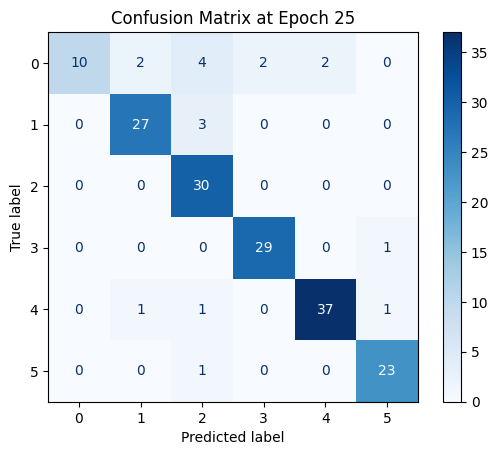

In val 
+----------------------------------------------------------------------------+
+                           Pytorch Model Summary                            +
------------------------------------------------------------------------------
   Layer (type)       Input Shape      Output Shape    Param #      FLOPS #
       Conv2d-1     (1, 1, 16000)     (15, 1, 7996)        135    1,079,460
  BatchNorm2d-2     (15, 1, 7996)     (15, 1, 7996)         30            0
         ReLu-3     (15, 1, 7996)     (15, 1, 7996)          0      119,940
       Conv2d-4     (15, 1, 7996)     (32, 1, 3996)      2,400    9,590,400
  BatchNorm2d-5     (32, 1, 3996)     (32, 1, 3996)         64            0
         ReLu-6     (32, 1, 3996)     (32, 1, 3996)          0      127,872
    MaxPool2d-7     (32, 1, 3996)       (32, 1, 99)          0      126,720
      Permute-8       (32, 1, 99)       (1, 32, 99)          0            0
       Conv2d-9       (1, 32, 99)      (58, 32, 99)        522    1,653

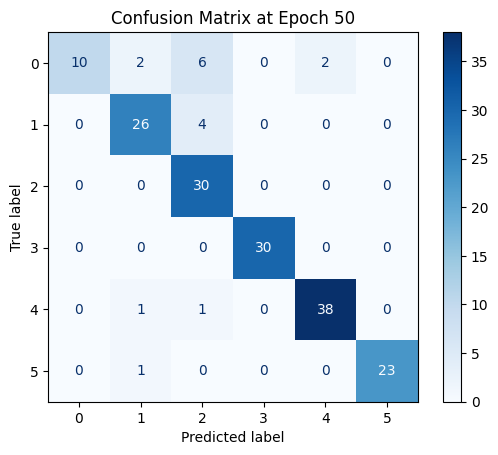

In val 
+----------------------------------------------------------------------------+
+                           Pytorch Model Summary                            +
------------------------------------------------------------------------------
   Layer (type)       Input Shape      Output Shape    Param #      FLOPS #
       Conv2d-1     (1, 1, 16000)     (14, 1, 7996)        126    1,007,496
  BatchNorm2d-2     (14, 1, 7996)     (14, 1, 7996)         28            0
         ReLu-3     (14, 1, 7996)     (14, 1, 7996)          0      111,944
       Conv2d-4     (14, 1, 7996)     (32, 1, 3996)      2,240    8,951,040
  BatchNorm2d-5     (32, 1, 3996)     (32, 1, 3996)         64            0
         ReLu-6     (32, 1, 3996)     (32, 1, 3996)          0      127,872
    MaxPool2d-7     (32, 1, 3996)       (32, 1, 99)          0      126,720
      Permute-8       (32, 1, 99)       (1, 32, 99)          0            0
       Conv2d-9       (1, 32, 99)      (50, 32, 99)        450    1,425

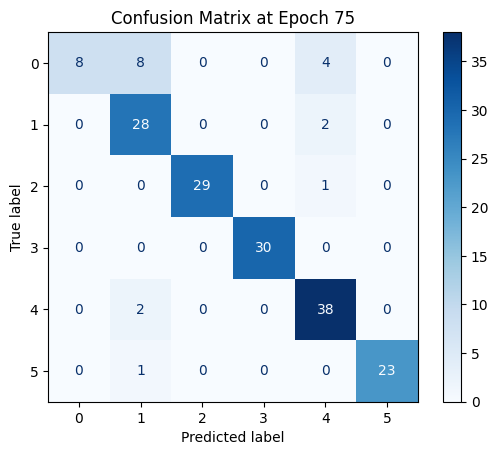

In val 
+----------------------------------------------------------------------------+
+                           Pytorch Model Summary                            +
------------------------------------------------------------------------------
   Layer (type)       Input Shape      Output Shape    Param #      FLOPS #
       Conv2d-1     (1, 1, 16000)     (12, 1, 7996)        108      863,568
  BatchNorm2d-2     (12, 1, 7996)     (12, 1, 7996)         24            0
         ReLu-3     (12, 1, 7996)     (12, 1, 7996)          0       95,952
       Conv2d-4     (12, 1, 7996)     (32, 1, 3996)      1,920    7,672,320
  BatchNorm2d-5     (32, 1, 3996)     (32, 1, 3996)         64            0
         ReLu-6     (32, 1, 3996)     (32, 1, 3996)          0      127,872
    MaxPool2d-7     (32, 1, 3996)       (32, 1, 99)          0      126,720
      Permute-8       (32, 1, 99)       (1, 32, 99)          0            0
       Conv2d-9       (1, 32, 99)      (40, 32, 99)        360    1,140

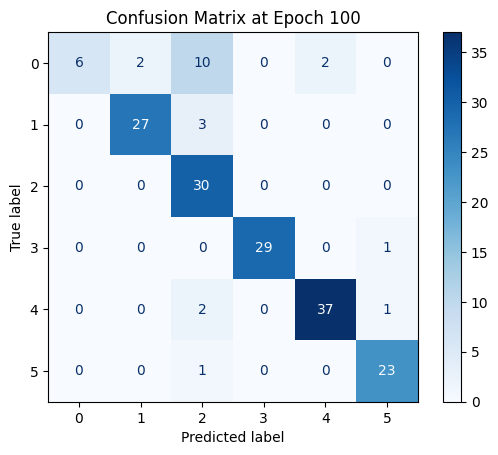

In val 
+----------------------------------------------------------------------------+
+                           Pytorch Model Summary                            +
------------------------------------------------------------------------------
   Layer (type)       Input Shape      Output Shape    Param #      FLOPS #
       Conv2d-1     (1, 1, 16000)     (11, 1, 7996)         99      791,604
  BatchNorm2d-2     (11, 1, 7996)     (11, 1, 7996)         22            0
         ReLu-3     (11, 1, 7996)     (11, 1, 7996)          0       87,956
       Conv2d-4     (11, 1, 7996)     (32, 1, 3996)      1,760    7,032,960
  BatchNorm2d-5     (32, 1, 3996)     (32, 1, 3996)         64            0
         ReLu-6     (32, 1, 3996)     (32, 1, 3996)          0      127,872
    MaxPool2d-7     (32, 1, 3996)       (32, 1, 99)          0      126,720
      Permute-8       (32, 1, 99)       (1, 32, 99)          0            0
       Conv2d-9       (1, 32, 99)      (31, 32, 99)        279      883

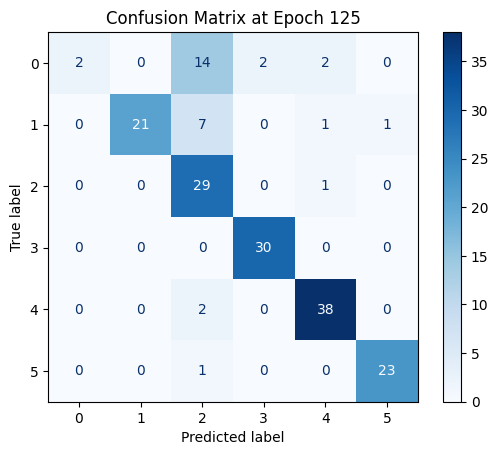

In val 
+----------------------------------------------------------------------------+
+                           Pytorch Model Summary                            +
------------------------------------------------------------------------------
   Layer (type)       Input Shape      Output Shape    Param #      FLOPS #
       Conv2d-1     (1, 1, 16000)      (8, 1, 7996)         72      575,712
  BatchNorm2d-2      (8, 1, 7996)      (8, 1, 7996)         16            0
         ReLu-3      (8, 1, 7996)      (8, 1, 7996)          0       63,968
       Conv2d-4      (8, 1, 7996)     (32, 1, 3996)      1,280    5,114,880
  BatchNorm2d-5     (32, 1, 3996)     (32, 1, 3996)         64            0
         ReLu-6     (32, 1, 3996)     (32, 1, 3996)          0      127,872
    MaxPool2d-7     (32, 1, 3996)       (32, 1, 99)          0      126,720
      Permute-8       (32, 1, 99)       (1, 32, 99)          0            0
       Conv2d-9       (1, 32, 99)      (21, 32, 99)        189      598

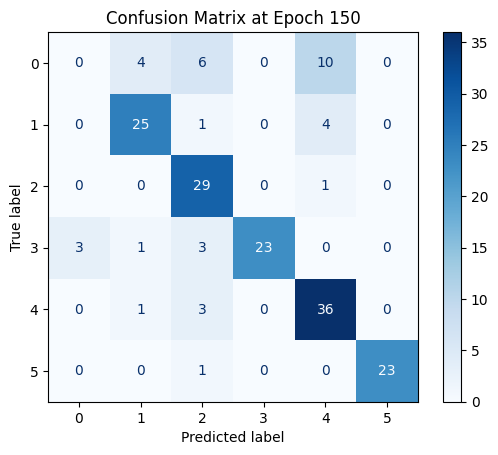

In val 
+----------------------------------------------------------------------------+
+                           Pytorch Model Summary                            +
------------------------------------------------------------------------------
   Layer (type)       Input Shape      Output Shape    Param #      FLOPS #
       Conv2d-1     (1, 1, 16000)      (6, 1, 7996)         54      431,784
  BatchNorm2d-2      (6, 1, 7996)      (6, 1, 7996)         12            0
         ReLu-3      (6, 1, 7996)      (6, 1, 7996)          0       47,976
       Conv2d-4      (6, 1, 7996)     (32, 1, 3996)        960    3,836,160
  BatchNorm2d-5     (32, 1, 3996)     (32, 1, 3996)         64            0
         ReLu-6     (32, 1, 3996)     (32, 1, 3996)          0      127,872
    MaxPool2d-7     (32, 1, 3996)       (32, 1, 99)          0      126,720
      Permute-8       (32, 1, 99)       (1, 32, 99)          0            0
       Conv2d-9       (1, 32, 99)      (13, 32, 99)        117      370

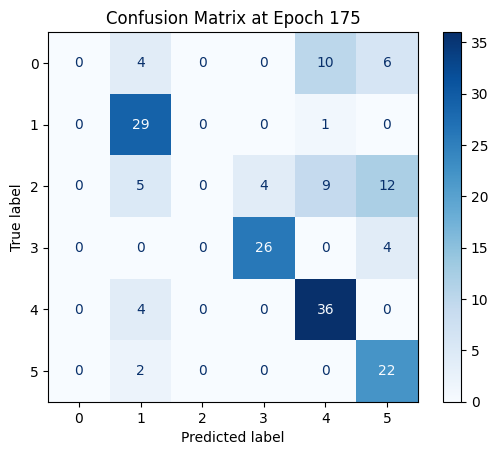

In val 
+----------------------------------------------------------------------------+
+                           Pytorch Model Summary                            +
------------------------------------------------------------------------------
   Layer (type)       Input Shape      Output Shape    Param #      FLOPS #
       Conv2d-1     (1, 1, 16000)      (5, 1, 7996)         45      359,820
  BatchNorm2d-2      (5, 1, 7996)      (5, 1, 7996)         10            0
         ReLu-3      (5, 1, 7996)      (5, 1, 7996)          0       39,980
       Conv2d-4      (5, 1, 7996)     (32, 1, 3996)        800    3,196,800
  BatchNorm2d-5     (32, 1, 3996)     (32, 1, 3996)         64            0
         ReLu-6     (32, 1, 3996)     (32, 1, 3996)          0      127,872
    MaxPool2d-7     (32, 1, 3996)       (32, 1, 99)          0      126,720
      Permute-8       (32, 1, 99)       (1, 32, 99)          0            0
       Conv2d-9       (1, 32, 99)       (9, 32, 99)         81      256

In [ ]:
step_3_model_path = main()

In [ ]:
step_3_model_path 

'/home/sail/sound_project/sound_ai_v3/sys/step_5_conv_int8/save_pt_model_s5/20241029_23/uec_secondPrun_time_2024103008_prunratio70.0/6C_model_v3second_stage_prun_ratio0.7_20241030085712.pt'

## step4

In [ ]:
# step_3_model_path = '/home/sail/sound_project/sound_ai_v3/sys/step_3_pruning/20241025_18/uec_secondPrun_time_2024102518_prunratio90.0/6C_model_v3second_stage_prun_ratio0.9_20241025182638.pt'

In [ ]:
step_now = 'sys/step_4_retrain'
date_time = datetime.now().strftime("%Y%m%d_%H")  # %M
save_step_path = f'{project_PATH}/{step_now}'
save_pt_model_path = f'{save_step_path}/{date_time}'

try:
    os.mkdir(f'{project_PATH}/{step_now}')
    os.mkdir(save_step_path)
    print(f"Folder '{save_step_path}' created successfully.")
except FileExistsError:
    print(f"Folder '{save_step_path}' already exists.")
    
save_step_path = f'{project_PATH}/{step_now}/save_pt_model_s4'
try:
    os.mkdir(f'{project_PATH}/{step_now}')
    os.mkdir(save_step_path)
    print(f"Folder '{save_step_path}' created successfully.")
except FileExistsError:
    print(f"Folder '{save_step_path}' already exists.")

try:
    os.mkdir(save_pt_model_path)
    print(f"Folder '{save_pt_model_path}' created successfully.")
except FileExistsError:
    print(f"Folder '{save_pt_model_path}' already exists.")

Folder '/home/sail/sound_project/sound_ai_v3/sys/step_4_retrain' already exists.
Folder '/home/sail/sound_project/sound_ai_v3/sys/step_4_retrain/save_pt_model_s4' already exists.
Folder '/home/sail/sound_project/sound_ai_v3/sys/step_4_retrain/20241030_10' created successfully.


In [ ]:
from retrain import ReTrainer

In [ ]:
def main():

    opt = getOpts();

    # opt.lr = 0.1
    # opt.nEpochs = ; # 1600
    # opt.schedule = [0.001, 0.003, 0.005, 0.01];
    # opt.warmup = 10;
    
    # opt.least_save_epoch = 10;
    opt.first_save_acc = 70.0;
    opt.save_val_acc = 95.0;
    opt.save_train_acc = 85.0;

    opt.pruningRatio = pr_rate
    
    save_dir = "{}/retrain_4C_after_2nd_pruning_prunratio{}_{}/".format(save_pt_model_path,opt.pruningRatio,getDateStr());
    if not os.path.exists(save_dir):
        os.mkdir(save_dir)
    opt.logSaveDir = save_dir
    print(f"save dir is: {save_dir}");
    opt.second_pruned_model = step_3_model_path

    opt.saveDir = save_dir;
    # opt.device="mps";
    if torch.cuda.is_available():
        opt.device="cuda:0"; #for nVidia gpu
    else:
        opt.device="cpu"
    print(f"***Use device:{opt.device}");
    # opt.device = torch.device("cuda:0" if  else "cpu");

    opt.model_name = save_model_name+"retrained_ratio{:.4f}_vaacc{:.4f}_tracc_{:.4f}@{}epoch.pt"
    
    #Starting retraining process
    trainer = ReTrainer(opt=opt);
    trainer.Train();
    return opt.best_save_name

***Use device:cuda:0
save dir is: /home/sail/sound_project/sound_ai_v3/sys/step_4_retrain/20241030_10/retrain_4C_after_2nd_pruning_prunratio0.9_2024103010/
***Use device:cuda:0
random other
random other
device is: cuda:0
config is [5, 32, 8, 6, 10, 7, 10]
self.opt.config [5, 32, 8, 6, 10, 7, 10]
+----------------------------------------------------------------------------+
+                           Pytorch Model Summary                            +
------------------------------------------------------------------------------
   Layer (type)       Input Shape      Output Shape    Param #      FLOPS #
       Conv2d-1     (1, 1, 16000)      (5, 1, 7996)         45      359,820
  BatchNorm2d-2      (5, 1, 7996)      (5, 1, 7996)         10            0
         ReLu-3      (5, 1, 7996)      (5, 1, 7996)          0       39,980
       Conv2d-4      (5, 1, 7996)     (32, 1, 3996)        800    3,196,800
  BatchNorm2d-5     (32, 1, 3996)     (32, 1, 3996)         64            0
         R

/home/sail/sound_project/sound_ai_v3/sys/retrain.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(self.opt.second_pruned_model, map_location="cuda")


shape of y_pred:torch.Size([174, 6])
shape of y_target:torch.Size([174, 6])
SP-[1] Epoch: 1/100 | Time: 0m17s (Train 0m17s  Val 0m00s) | Train: LR 0.010000000000000002  Loss 1.00  Acc 71.76% | Val: Loss 0.04  Acc(top1) 63.79%  HA 0.00| best sum 0.00@0


/home/sail/sound_project/sound_ai_v3/sys/retrain.py:190: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x)


shape of y_pred:torch.Size([174, 6])
shape of y_target:torch.Size([174, 6])
SP-[1] Epoch: 2/100 | Time: 0m16s (Train 0m16s  Val 0m00s) | Train: LR 0.010000000000000002  Loss 0.98  Acc 73.27% | Val: Loss inf  Acc(top1) 63.79%  HA 0.00| best sum 0.00@0
shape of y_pred:torch.Size([174, 6])
shape of y_target:torch.Size([174, 6])
SP-[1] Epoch: 3/100 | Time: 0m16s (Train 0m16s  Val 0m00s) | Train: LR 0.010000000000000002  Loss 0.96  Acc 72.52% | Val: Loss nan  Acc(top1) 70.69%  HA 0.00| best sum 0.00@0
shape of y_pred:torch.Size([174, 6])
shape of y_target:torch.Size([174, 6])
SP-[1] Epoch: 4/100 | Time: 0m17s (Train 0m17s  Val 0m00s) | Train: LR 0.010000000000000002  Loss 0.95  Acc 72.43% | Val: Loss nan  Acc(top1) 70.11%  HA 0.00| best sum 0.00@0
shape of y_pred:torch.Size([174, 6])
shape of y_target:torch.Size([174, 6])
SP-[1] Epoch: 5/100 | Time: 0m16s (Train 0m16s  Val 0m00s) | Train: LR 0.010000000000000002  Loss 0.94  Acc 72.46% | Val: Loss nan  Acc(top1) 73.56%  HA 0.00| best sum 0.0

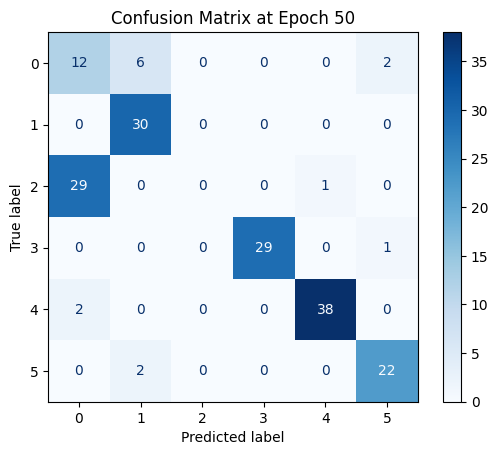

/home/uecai/.local/lib/python3.10/site-packages/matplotlib/axes/_base.py:2985: RuntimeWarning: overflow encountered in scalar add
  x0, x1 = inverse_trans.transform([x0t - delta, x1t + delta])


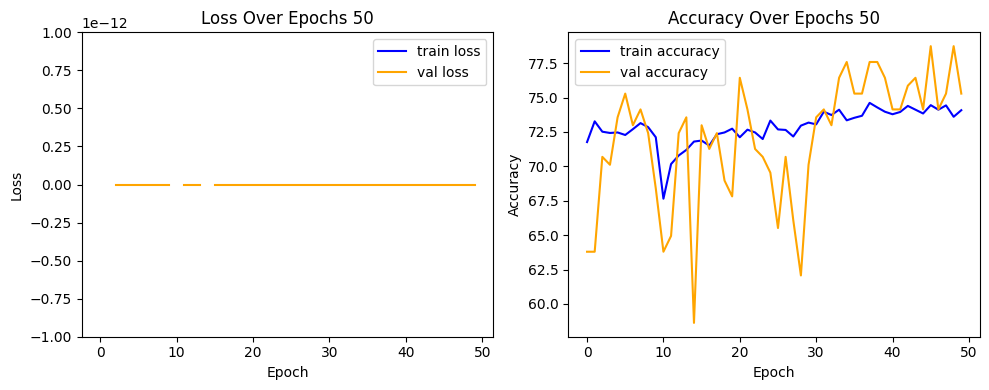

shape of y_pred:torch.Size([174, 6])
shape of y_target:torch.Size([174, 6])
SP-[1] Epoch: 51/100 | Time: 0m17s (Train 0m16s  Val 0m00s) | Train: LR 0.0010000000000000002  Loss 0.92  Acc 73.99% | Val: Loss nan  Acc(top1) 76.44%  HA 78.74| best sum 306.53@49


/home/sail/sound_project/sound_ai_v3/sys/retrain.py:190: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x)


shape of y_pred:torch.Size([174, 6])
shape of y_target:torch.Size([174, 6])
SP-[1] Epoch: 52/100 | Time: 0m17s (Train 0m17s  Val 0m00s) | Train: LR 0.0010000000000000002  Loss 0.92  Acc 74.23% | Val: Loss nan  Acc(top1) 77.59%  HA 78.74| best sum 306.53@49
shape of y_pred:torch.Size([174, 6])
shape of y_target:torch.Size([174, 6])
SP-[1] Epoch: 53/100 | Time: 0m17s (Train 0m17s  Val 0m00s) | Train: LR 0.0010000000000000002  Loss 0.92  Acc 73.90% | Val: Loss nan  Acc(top1) 76.44%  HA 78.74| best sum 306.53@49
shape of y_pred:torch.Size([174, 6])
shape of y_target:torch.Size([174, 6])
SP-[1] Epoch: 54/100 | Time: 0m16s (Train 0m16s  Val 0m00s) | Train: LR 0.0010000000000000002  Loss 0.92  Acc 74.26% | Val: Loss nan  Acc(top1) 77.59%  HA 78.74| best sum 306.53@49
shape of y_pred:torch.Size([174, 6])
shape of y_target:torch.Size([174, 6])
SP-[1] Epoch: 55/100 | Time: 0m17s (Train 0m17s  Val 0m00s) | Train: LR 0.0010000000000000002  Loss 0.92  Acc 73.99% | Val: Loss nan  Acc(top1) 76.44%  H

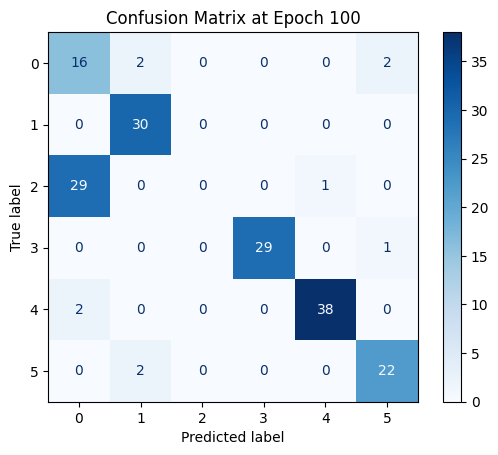

/home/uecai/.local/lib/python3.10/site-packages/matplotlib/axes/_base.py:2985: RuntimeWarning: overflow encountered in scalar add
  x0, x1 = inverse_trans.transform([x0t - delta, x1t + delta])


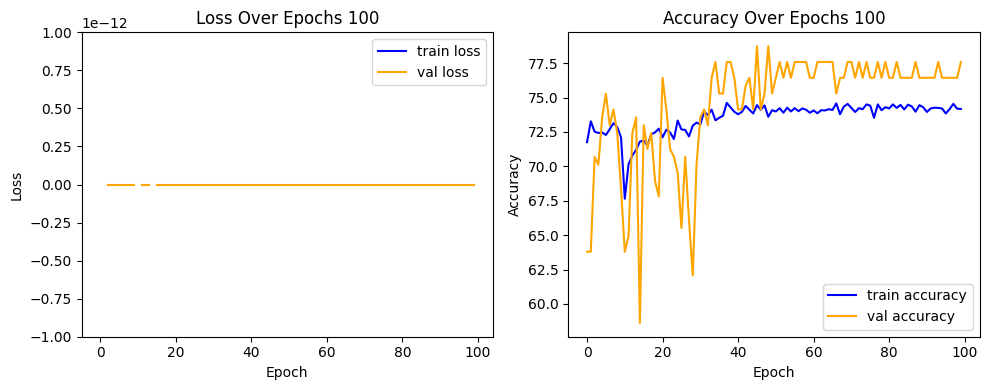

Execution finished in: 28m10s


In [ ]:
step_4_model_path = main()

In [ ]:
step_4_model_path

'/home/sail/sound_project/sound_ai_v3/sys/step_4_retrain/20241030_10/retrain_4C_after_2nd_pruning_prunratio0.9_2024103010/6C_model_v3retrained_ratio90.0000_vaacc78.7356_tracc_74.4485@46epoch.pt'

## step5

In [ ]:
# step_4_model_path = '/home/sail/sound_project/sound_ai_v3/sys/step_4_retrain/20241028_09/retrain_4C_after_2nd_pruning_prunratio0.9_2024102809/6C_model_v3retrained_ratio90.0000_vaacc95.4023_tracc_90.8088@285epoch.pt'

In [ ]:
step_now = 'sys/step_5_conv_int8'
date_time = datetime.now().strftime("%Y%m%d_%H")  # %M
save_step_path = f'{project_PATH}/{step_now}/save_pt_model_s5'
save_pt_model_path = f'{save_step_path}/{date_time}'


In [ ]:
date_time = datetime.now().strftime("%Y%m%d_%H")  # %M
save_pt_model_path = f'{project_PATH}/{step_now}/save_pt_model_s5'

save_tflite_model_path = f'{project_PATH}/{step_now}/save_tflite_model_s5'
try:
    os.mkdir(save_pt_model_path)
    print(f"Folder '{save_pt_model_path}' created successfully.")
except FileExistsError:
    print(f"Folder '{save_pt_model_path}' already exists.")

try:
    os.mkdir(save_tflite_model_path)
    print(f"Folder '{save_tflite_model_path}' created successfully.")
except FileExistsError:
    print(f"Folder '{save_tflite_model_path}' already exists.")

save_pt_model_path = f'{project_PATH}/{step_now}/save_pt_model_s5/{date_time}'

save_tflite_model_path = f'{project_PATH}/{step_now}/save_tflite_model_s5/{date_time}'
try:
    os.mkdir(save_pt_model_path)
    print(f"Folder '{save_pt_model_path}' created successfully.")
except FileExistsError:
    print(f"Folder '{save_pt_model_path}' already exists.")

try:
    os.mkdir(save_pt_model_path+'/uncompressed_qat_models')
    print(f"Folder '{save_pt_model_path}' created successfully.")
except FileExistsError:
    print(f"Folder '{save_pt_model_path}' already exists.")
    
try:
    os.mkdir(save_tflite_model_path)
    print(f"Folder '{save_tflite_model_path}' created successfully.")
except FileExistsError:
    print(f"Folder '{save_tflite_model_path}' already exists.")

Folder '/home/sail/sound_project/sound_ai_v3/sys/step_5_conv_int8/save_pt_model_s5' already exists.
Folder '/home/sail/sound_project/sound_ai_v3/sys/step_5_conv_int8/save_tflite_model_s5' already exists.
Folder '/home/sail/sound_project/sound_ai_v3/sys/step_5_conv_int8/save_pt_model_s5/20241030_11' created successfully.
Folder '/home/sail/sound_project/sound_ai_v3/sys/step_5_conv_int8/save_pt_model_s5/20241030_11' created successfully.
Folder '/home/sail/sound_project/sound_ai_v3/sys/step_5_conv_int8/save_tflite_model_s5/20241030_11' created successfully.


In [ ]:
def display_info(opt):
    print('+------------------------------+');
    print('| {} Sound classification'.format(opt.netType));
    print('+------------------------------+');
    print('| dataset  : {}'.format(opt.dataset));
    print('| nEpochs  : {}'.format(opt.nEpochs));
    print('| LRInit   : {}'.format(opt.lr));
    print('| schedule : {}'.format(opt.schedule));
    print('| warmup   : {}'.format(opt.warmup));
    print('| batchSize: {}'.format(opt.batchSize));
    print('| nFolds: {}'.format(opt.nFolds));
    print('| Splits: {}'.format(opt.splits));
    print('| Device: {}'.format(opt.device));
    print('| Model Path: {}'.format(opt.model_path));
    print('| Model Name: {}'.format(opt.model_name));
    print('+------------------------------+');

In [ ]:
from convint8 import QATTrainer

In [ ]:
def main():
    opt = getOpts();#opts.parse();
    opt.device = 'cpu';
    opt.saveInfo = "uec_v2.2_sail1014"
    opt.model_path = step_4_model_path

    opt.save_tflite_model_path = save_tflite_model_path
    opt.logSaveDir = opt.save_tflite_model_path 
    opt.save_pt_model_path = save_pt_model_path
    timeStr = genDataTimeStr();
    opt.model_name = save_model_name+"qat_model_{}_{}".format(opt.saveInfo,timeStr);
   
    opt.lr = 0.01; # 0.1
    opt.nEpochs = ; # 1600
    # opt.schedule = [0.05, 0.1, 0.3, 0.5];
    opt.schedule = [0.001, 0.003, 0.005, 0.01];
    # opt.warmup = 10;

    opt.split = 1;
    opt.hasQuated = False;
    display_info(opt);
    trainer = QATTrainer(opt);

    print('Testing performance of the provided model.....');
    trainer.TestModel();

    print('Quantization process is started.....');
    trainer.QuantizeModel();
    print('Quantization done');

    return opt.tflite_path
    # print('Testing quantized model.');
    # trainer.TestModel(True);
    # print('Finished');

***Use device:cuda:0
+------------------------------+
| add_attention Sound classification
+------------------------------+
| dataset  : v2.2.2
| nEpochs  : 50
| LRInit   : 0.01
| schedule : [0.001, 0.003, 0.005, 0.01]
| warmup   : 10
| batchSize: 64
| nFolds: 1
| Splits: [1]
| Device: cpu
| Model Path: /home/sail/sound_project/sound_ai_v3/sys/step_4_retrain/20241030_10/retrain_4C_after_2nd_pruning_prunratio0.9_2024103010/6C_model_v3retrained_ratio90.0000_vaacc78.7356_tracc_74.4485@46epoch.pt
| Model Name: 6C_model_v3qat_model_uec_v2.2_sail1014_20241030112104
+------------------------------+
random other
random other
device is: cpu
Testing performance of the provided model.....
has not quanted, load unquanted model...
[1, 5, 32, 1, 8, 6, 10, 7, 10, 6]
self.ch_config [1, 5, 32, 1, 8, 6, 10, 7, 10, 6]
+----------------------------------------------------------------------------+
+                           Pytorch Model Summary                            +
-------------------------------

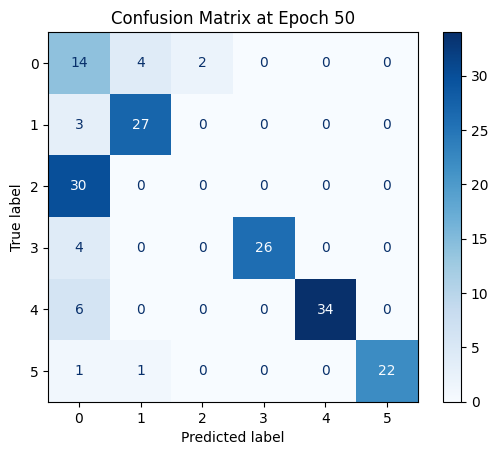

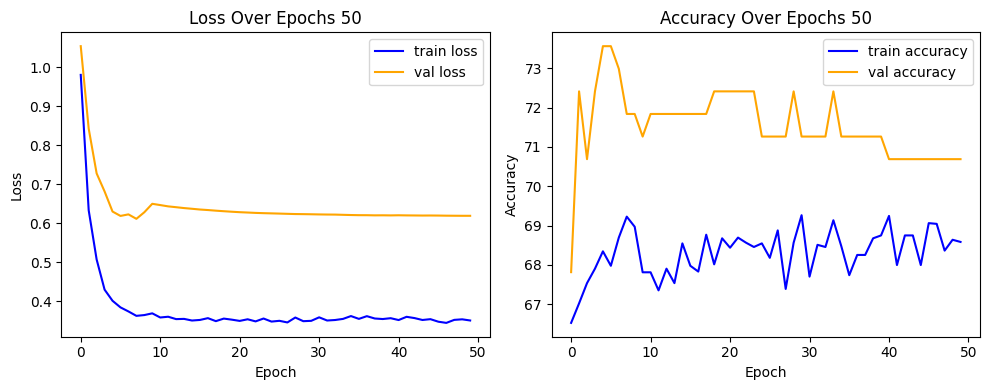

Execution finished in: 12m56s
Post Training Quantization: Convert done
Size of model after quantization
Size (MB): 0.01363
device is: cpu
torch.Size([174, 6])
Testing: Acc(top1) 71.26%


INFO (tinynn.converter.base) Generated model saved to /home/sail/sound_project/sound_ai_v3/sys/step_5_conv_int8/save_tflite_model_s5/20241030_11/6C_model_v3qat_model_uec_v2.2_sail1014_20241030112104.tflite


Quantization done


In [ ]:
tflite_path = main()

## check

In [ ]:
tflite_path

'/home/sail/sound_project/sound_ai_v3/sys/step_5_conv_int8/save_tflite_model_s5/20241030_11/6C_model_v3qat_model_uec_v2.2_sail1014_20241030112104.tflite'

In [ ]:
import tensorflow as tf


interpreter = tf.lite.Interpreter(model_path=tflite_path)

interpreter.allocate_tensors()

# 獲取張量細節
tensor_details = interpreter.get_tensor_details()

# 檢查每個張量的類型
for tensor in tensor_details:
    tensor_name = tensor['name']
    tensor_type = tensor['dtype']
    print(f"Tensor: {tensor_name}, Type: {tensor_type}")

# 檢查輸入和輸出張量的類型
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("\nInput Tensors:")
for input_tensor in input_details:
    print(f"Name: {input_tensor['name']}, Type: {input_tensor['dtype']}")

print("\nOutput Tensors:")
for output_tensor in output_details:
    print(f"Name: {output_tensor['name']}, Type: {output_tensor['dtype']}")


Tensor: x.1_transform, Type: <class 'numpy.int8'>
Tensor: Xq.1_attr, Type: <class 'numpy.int8'>
Tensor: input0.1_attr_1, Type: <class 'numpy.int32'>
Tensor: input.14_te_transform_1_te_attr_2, Type: <class 'numpy.int32'>
Tensor: input.14_te_transform_1_te_transform_2, Type: <class 'numpy.int8'>
Tensor: input.14_te_transform, Type: <class 'numpy.int8'>
Tensor: fuse_attr_7, Type: <class 'numpy.int8'>
Tensor: fuse_attr_5, Type: <class 'numpy.int8'>
Tensor: fuse_attr_2, Type: <class 'numpy.int32'>
Tensor: Xq.1_attr_1, Type: <class 'numpy.int32'>
Tensor: input.12_te_transform, Type: <class 'numpy.int8'>
Tensor: input.1_transform, Type: <class 'numpy.int8'>
Tensor: fuse_attr_4, Type: <class 'numpy.int8'>
Tensor: input.1_transform_1, Type: <class 'numpy.int8'>
Tensor: 124, Type: <class 'numpy.int8'>
Tensor: input.12_attr_1, Type: <class 'numpy.int32'>
Tensor: input0.1_te_transform, Type: <class 'numpy.int8'>
Tensor: input.7_te_transform, Type: <class 'numpy.int8'>
Tensor: x.1_transform_1, Type

In [ ]:
tensor_details

[{'name': 'x.1_transform',
  'index': 0,
  'shape': array([   1,    1, 3996,   32], dtype=int32),
  'shape_signature': array([   1,    1, 3996,   32], dtype=int32),
  'dtype': numpy.int8,
  'quantization': (0.0205623060464859, -128),
  'quantization_parameters': {'scales': array([0.02056231], dtype=float32),
   'zero_points': array([-128], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}},
 {'name': 'Xq.1_attr',
  'index': 1,
  'shape': array([ 6, 10], dtype=int32),
  'shape_signature': array([ 6, 10], dtype=int32),
  'dtype': numpy.int8,
  'quantization': (0.018355820327997208, 0),
  'quantization_parameters': {'scales': array([0.01835582], dtype=float32),
   'zero_points': array([0], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}},
 {'name': 'input0.1_attr_1',
  'index': 2,
  'shape': array([8], dtype=int32),
  'shape_signature': array([8], dtype=int32),
  'dtype': numpy.int32,
  'quantization': (6.24337189947255e-05, 0),
  'quantizatio

# 

In [ ]:
tflite_ = tflite_path
tflite_.split('/')[0]

''

In [ ]:
c_ = f"/{tflite_.split('/')[1]}/{tflite_.split('/')[2]}/{tflite_.split('/')[3]}/{tflite_.split('/')[4]}/{tflite_.split('/')[5]}/{tflite_.split('/')[6]}/{tflite_.split('/')[7]}/{tflite_.split('/')[8]}/{save_name}"#tflite_[:-7]+'.cc'

! xxd -i {tflite_} > {c_}
REPLACE_TEST = "model_6c_1028_bysail";
!sed -i 's/'{REPLACE_TEST}'/g_model/g' {c_}

In [ ]:
import tensorflow as tf
import numpy as np

def calculate_arena_size(tflite_model_path):
    """
    計算 TFLite 模型的內存需求（Arena size）。

    :param tflite_model_path: .tflite 模型文件的路徑
    :return: 估算的總內存需求（MB）
    """
    # 加載 TFLite 模型
    interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
    interpreter.allocate_tensors()

    # 獲取所有張量的詳細信息
    tensor_details = interpreter.get_tensor_details()

    # 計算參數內存
    total_params = 0
    params_memory = 0
    activations_memory = 0

    for tensor in tensor_details:
        name = tensor['name'].lower()
        shape = tensor['shape']
        dtype = tensor['dtype']

        # 根據數據類型確定每個元素的字節數
        if dtype == np.float32:
            bytes_per_element = 4
        elif dtype == np.int8:
            bytes_per_element = 1
        elif dtype == np.int16:
            bytes_per_element = 2
        elif dtype == np.uint8:
            bytes_per_element = 1
        else:
            bytes_per_element = 4  # 默認為 float32

        tensor_size_mb = (np.prod(shape) * bytes_per_element) / (1024 ** 2)  # 轉換為 MB

        # 假設 'weight' 和 'bias' 為參數，其他為激活
        if 'weight' in name or 'bias' in name:
            total_params += np.prod(shape)
            params_memory += (np.prod(shape) * bytes_per_element) / (1024 ** 2)  # MB
        else:
            activations_memory += tensor_size_mb  # MB

    # 臨時內存估算（假設激活內存的 20% 為臨時內存）
    temporary_memory = activations_memory * 0.2

    # 總內存需求
    total_memory = params_memory + activations_memory + temporary_memory

    print(f"dtype：{dtype} ")
    print(f"參數內存需求：{params_memory:.2f} MB")
    print(f"激活內存需求：{activations_memory:.2f} MB")
    print(f"臨時內存需求（估算）：{temporary_memory:.2f} MB")
    print(f"總內存需求（估算的 Arena size）：{total_memory:.2f} MB")

    return total_memory

# 使用範例
tflite_model = tflite_path
arena_size = calculate_arena_size(tflite_model)

dtype：<class 'numpy.int32'> 
參數內存需求：0.00 MB
激活內存需求：0.22 MB
臨時內存需求（估算）：0.04 MB
總內存需求（估算的 Arena size）：0.26 MB


In [ ]:
# import tensorflow as tf


# interpreter = tf.lite.Interpreter(model_path='/hd/Rick/desktop/Works/Projects/TransferLearning_for_ACDNet/Finall_Models_Save/Alarm_Detection/Pruning_Ratio_0.6_0.85_20240221/qat_model_0.6_0.85_ratio_qatacc_95.4_20240221181601_total_epochs_200.tflite')

# interpreter.allocate_tensors()

# # 獲取張量細節
# tensor_details = interpreter.get_tensor_details()

# # 檢查每個張量的類型
# for tensor in tensor_details:
#     tensor_name = tensor['name']
#     tensor_type = tensor['dtype']
#     print(f"Tensor: {tensor_name}, Type: {tensor_type}")

# # 檢查輸入和輸出張量的類型
# input_details = interpreter.get_input_details()
# output_details = interpreter.get_output_details()

# print("\nInput Tensors:")
# for input_tensor in input_details:
#     print(f"Name: {input_tensor['name']}, Type: {input_tensor['dtype']}")

# print("\nOutput Tensors:")
# for output_tensor in output_details:
#     print(f"Name: {output_tensor['name']}, Type: {output_tensor['dtype']}")


In [ ]:
# tensor_details

In [ ]:
# import re

# # 假設模型數據存儲在名為 model.cc 的文件中
# input_file = '/home/sail/sound_project/sound_ai_v2/sys/step_5_conv_int8/save_tflite_model_s5/20241015_09/model_6C_v222_1015_pr09_byChristine.cc'
# output_file = 'model.tflite'

# # 讀取 C 文件
# with open(input_file, 'r') as f:
#     data = f.read()

# # 正則表達式匹配模型數據陣列
# match = re.search(r'unsigned char [^;]+', data, re.DOTALL)
# if not match:
#     raise ValueError("未找到模型數據陣列。請檢查文件內容。")

# # 提取十六進制數據
# hex_data = match.group(0)
# hex_values = re.findall(r'0x([0-9A-Fa-f]{2})', hex_data)

# # 將十六進制轉換為二進制
# binary_data = bytes(int(h, 16) for h in hex_values)

# # 保存為 .tflite 文件
# with open(output_file, 'wb') as f:
#     f.write(binary_data)



In [ ]:
# import tensorflow as tf


# interpreter = tf.lite.Interpreter(model_path=output_file)

# interpreter.allocate_tensors()

# # 獲取張量細節
# tensor_details = interpreter.get_tensor_details()

# # 檢查每個張量的類型
# for tensor in tensor_details:
#     tensor_name = tensor['name']
#     tensor_type = tensor['dtype']
#     print(f"Tensor: {tensor_name}, Type: {tensor_type}")

# # 檢查輸入和輸出張量的類型
# input_details = interpreter.get_input_details()
# output_details = interpreter.get_output_details()

# print("\nInput Tensors:")
# for input_tensor in input_details:
#     print(f"Name: {input_tensor['name']}, Type: {input_tensor['dtype']}")

# print("\nOutput Tensors:")
# for output_tensor in output_details:
#     print(f"Name: {output_tensor['name']}, Type: {output_tensor['dtype']}")
